<a href="https://colab.research.google.com/github/tmgrupoinmobiliario/sales-prediction-ml/blob/master/Predicting_Housing_Sales_Mediterranean_Area.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Housing Sales in Mediterranean Area


The prediction target is the Unit Sale given its features such as area, nacionality, year sale in and so on. The model is evaluated on the root mean square error between your predictions and the truth value.


## Setup

In [0]:
!pip install fastai==0.7.0 > /dev/null
!pip install torchtext==0.2.3 > /dev/null 
!pip install --upgrade setuptools > /dev/null
!pip install scikit-misc==0.1.0 > /dev/null
!pip install pdpbox==0.2.0 > /dev/null
!pip install treeinterpreter==0.2.2 > /dev/null

In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Libraries

In [0]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics


## Load Data Set

In [0]:
from google.colab import files
uploaded=files.upload()

Saving DataSetVentasReducido5.csv to DataSetVentasReducido5.csv


In [0]:
df_raw = pd.read_csv(f'DataSetVentasReducido5.csv', low_memory=False,delimiter=';')

In [0]:
len(df_raw)

In [0]:
df_raw

In [0]:
display(df_raw.dtypes)

Anyo           int64
Unidades       int64
Zona          object
Residencia     int64
Mercado       object
dtype: object

## Categorize string data

In [0]:
train_cats(df_raw)

In [0]:
display(df_raw.dtypes)

In [0]:
df_raw.Unidades.describe()

In [0]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/sales-raw')

In [0]:
df_raw = pd.read_feather('tmp/sales-raw')

In [0]:
df, y, nas = proc_df(df_raw, 'Unidades')

## ## Pre-procesado

In [0]:
RandomForestRegressor

sklearn.ensemble.forest.RandomForestRegressor

In [0]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9485513864892815

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split (df,y,test_size=0.2)

## Random Forest

In [0]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [0]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 15.6 ms, sys: 1.11 ms, total: 16.8 ms
Wall time: 108 ms
[19.52931320026575, 35.0744712944524, 0.9244431983124226, 0.7161783280741166]


## Single Tree

In [0]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[50.70752064279547, 53.83450060124428, 0.49061708151423605, 0.33137183790544733]


In [0]:
draw_tree(m.estimators_[0], X_train, precision=3)

## Categories

In [0]:
for column in df_raw.columns:
  if pd.api.types.is_categorical_dtype(df_raw[column]):
   #print(type(df_raw[column].dtype))
      print("column %s \n %s" % (column, df_raw[column].cat.categories))
      print('--------------------------------------------- \n')

column Zona 
 Index(['Alicante', 'Costa Blanca Norte', 'Costa Blanca Sur', 'Costa Cálida',
       'Costa de Almería', 'Costa del Sol', 'Mallorca', 'Murcia'],
      dtype='object')
--------------------------------------------- 

column Mercado 
 Index(['I', 'N'], dtype='object')
--------------------------------------------- 



## Bagging

In [0]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[17.085285344665504, 33.9989490511893, 0.9421712109760468, 0.7333176503817599]


In [0]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([ 29., 155., 213., 117., 155., 155., 117., 155., 155., 155.]),
 140.6,
 111)

In [0]:
preds.shape

(10, 41)

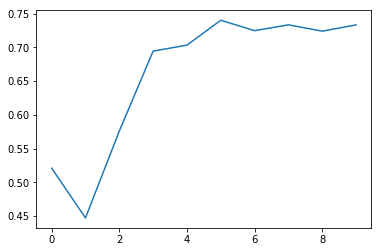

In [0]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

## Out-of-bag (OOB) score

In [0]:
m = RandomForestRegressor(n_estimators=8, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[20.245639009914036, 39.549087667933044, 0.9187987709185034, 0.6391420924889272, 0.48738166925113746]


In [0]:
m = RandomForestRegressor(n_estimators=8, n_jobs=-1, oob_score=True,max_features=0.5)
m.fit(X_train, y_train)
print_score(m)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[17.77157009675014, 34.027371962626304, 0.9374321512705236, 0.7328715744066638, 0.6072557115512138]


In [0]:
print((m.predict([[2020,2,2,1]])))

[92.25]
